## Group 3 Mobile Robotics Report

**Group Members**: Luca Engel, Marc Nassif,  Giuseppe De Carlo,  Giada Ehrlich



## Table of contents
1. [Introduction](#1-introduction)
2. [Setup](#2-setup)
      - 2.1 [Vision](#3-global-navigation)
3. [Implementation](#2-implementation)
      - 3.1 [Vision](#3-global-navigation)
         -  [Implementation Details](#31-implementation-details)
         -  [Functions](#32-functions)
      - 3.2 [Global Navigation](#4-vision)
         -  [Implementation Details](#41-implementation-details)
         -  [Functions](#42-functions)
      - 3.3 [Motion Control](#5-motion-control)
         -  [Implementation Details](#51-implementation-details)
         -  [Functions](#52-functions)
      - 3.4 [Local Navigation](#6-local-navigation)
         -  [Implementation Details](#61-implementation-details)
         -  [Functions](#62-functions)
      - 3.5 [Kalman Filter](#7-kalman-filter)
         - [Implementation Details](#71-implementation-details)
         - [Functions](#72-functions)
4. [Results](#4-results)
   - 4.1 [Summary](#41-summary)
   - 4.2 [Videos](#42-video)
5. [Conclusion](#4-conclusion)
   - 4.1 [Summary](#41-summary)
   - 4.2 [References](#42-references)


   






    

## 1. Introduction




In mobile robotics, fusing computer vision and sensor-based feedback is essential to establish reliable global navigation algorithms, motion control strategies, and sensor-based local obstacle avoidance to enable robots to intelligently and reliably navigate through dynamic environments. This report describes our effort to develop a solution that enables the Thymio robot to traverse a terrain containing obstacles and to reach a goal.

Our project integrates multiple technologies to improve the navigation precision. With the help of a video feed provided by a camera, computer vision is used to detect the map, the obstacles in the map, the Thymio robot, and the goal. Based on this information, a 2d grid of cells is constructed. The global navigation aspect employs the Dijkstra algorithm to calculate the shortest path from the Thymio to the goal, accounting for dynamically changing events, such as kidnapping where the Thymio or the goal are displaced. The motion control mechanism guided the Thymio along the calculated path which is discretized into intermediate points, facilitating a smooth and precise traversal. For local obstacle avoidance, the Thymio relies on its proximity sensors, allowing it to detect and navigate around obstacles not identified by the computer vision part. This ensures robust navigation, even when visual data is limited. The implementation of the Kalman filter for position and orientation estimation plays a pivotal role in this project. The filter combines information from the computer vision part and the wheel speeds of the Thymio to improve robustness of the navigation. The filter is even capable of functioning when the camera feed is obscured for a while, showing the robustness of our system.

This report details the design, implementation, and performance of our solution and shows how the combination of sensor data can drastically improve the capabilities and precision in robotic navigation.

## 2. Setup 


### Libraries required: 
- NumPy
- tmdclient
- OpenCV
- FilterPy

### Method overview: 

Thymio initially reads a global map from processed images acquired through the webcam. It subsequently extracts a path through global navigation and adheres to this route unless faced with kidnapping or local navigation triggers.

The provided schema illustrates the code structure implemented for this purpose. In cases where the camera becomes obscured, the robot continues to follow the pre-defined global path planning until the camera sensing functionality is restored.

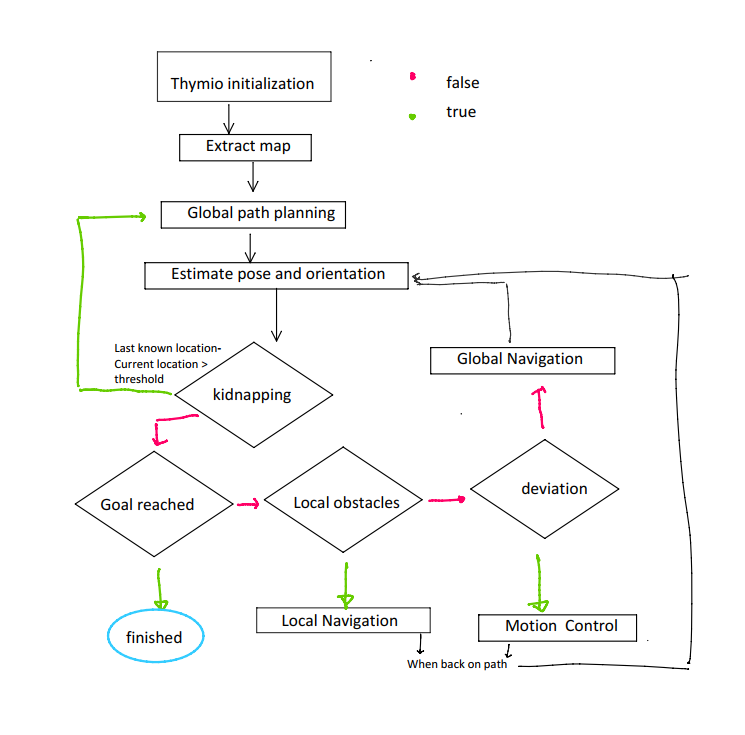

####  Environment


Webcam  : AUKEY 1080P

Map :
- White background 
- Global obstacles: black 
- Local obstacles: small 3-dimensional objects
- Markers: ArUco Markers



<img src="./report_images/set_image.png" alt="Image Alt Text" width="300" height="400"/>

*Set Up*

## 3. Implementation

### 3.1 Vision


Our vision system forms the baseline of the Thymio's understanding of the environment. Using the OpenCV library, the map is created in multiple steps, each of which extracting information from the camera feed, allowing our program to identify markers, determine their orientation, and recognize obstacles. In the following, our procedure will be shown with the example of the following image feed:

![Simple Camera Feed](./report_images/image_processing_images/simple_camera_feed.png)
*Unprocessed Camera Feed*


##### Marker Detection
We used OpenCV's ArUco marker detection algorithm to find the key elements and their orientation within the terrain, specifically, the Thymio robot, the goal, and the corners of the map. Based on this information, a transformation matrix is applied to the image to place the map corners into the corners of the image so that the map fills the entire video feed.

![Processed Image with Map Filling the Entire Screen](./report_images/image_processing_images/normal_feed_img.png)
*Processed Feed with Map Filling the Screen*

##### Grayscale Conversion and Thresholding
To simplify the object detection, we converted the camera feed to grayscale. As the objects are represented as black shaped, applying thresholding to the image allowed for easy extraction of their location in the environment.

![Binary Image](./report_images/image_processing_images/binary_img.png)
*Binary Image*

The resulting image still contains some noise due to the black thymio sensors being detected as obstacles. This is resolved in the next step. 

##### 2D Grid Representation
Based on the information obtained in the previous steps, a 2D grid of cells is created. Each cell stores information about its status, indicating whether it is free, occupied by the Thymio (green), the goal (blue), or an obstacle. 

After conversion, the 2D grid looks as follows:

![Grid Map with obstacles](./report_images/image_processing_images/grid_map_with_islands_not_increased_object_size.png)
*Grid Map with Obstacles*

Here, still, the map contains the noise from the black sensors of the Thymio and the ArUco markers of which some are not entirely erased from the map. This is solved by removing all obstacles that are detected to be small islands which results in the following:
![Grid Map with Islands Removed](./report_images/image_processing_images/grid_map_islands_removed_not_increased.png)
*Grid Map with Islands Removed*


Lastly, to account for the width of the Thymio, obstacles are artificially enlarged to ensure that the Thymio cannot drive too close to the obstacles. The resulting map looks as follows:

![Grid Map with Object Size Increased](./report_images/image_processing_images/grid_map_islands_removed_objects_increased.png)
*Grid Map with Object Size Increased*



##### Dynamic Updates
The grid is continuously updated with the positions of the Thymio and the goal within the map. These updates ensure that the Thymio can make informed decisions and enable recomputing the path after kidnapping events or motion control adjustments.

This part lays the groundwork for successful navigation of the Thymio robot in the terrain.

### 3.2 Global Navigation



Our global navigation system guides the Thymio robot throught the map by calculating the shortest path from its start location to the goal. This path is found with the Dijkstra algorithm. Similar to the vision, the navigation is also constructed in a multi-step approach.

##### Dijkstra Algorithm
The shortest path is calculated using the Dijkstra algorithm. The resulting path ensures that the Thymio can navigate through the environment while avoiding obstacles and ensures that it efficiently reaches the goal.

##### Path Discretization
To have the Thymio drive more smoothly, the computed path is discretized into a series of fewer cells. Each cell represents a direction change in the path. The Thymio receives these cells as intermediate goals allowing a more natural movement along the path and decreasing the number of sudden direction changes. The resulting path is marked red in the map and the direction changes purple. With this addition, the grid image looks as follows:

![Image Alt Text](./report_images/image_processing_images/grid_map_with_path.png)
*Grid Map Marked with Path and Direction Changes* 

##### Integration with Vision System
Based on the information received from the vision system, the path is calculated and obstacles can be avoided. Additionally, kidnapping of the thymio and the goal can be handled. Whenever such a kidnapping occurs, the path is recomputed so that the goal can be reached.


The combination of the Dijkstra algorithm, path discretization, and intermediate goal navigation, ensures a smooth and fast traversal of the map, even accounting for sudden events such as kidnapping.

### 3.3 Motion Control

details: 


### 3.4 Local Navigation

Local Navigation depends on the status of the proximity sensors. Since, in our project, the robot does not move backwards, the sensors at the back of the Thymio are ignored. An instance of the `LocalNavigation` class tracks the variables relevant to local navigation and is instantiated at program startup. On every iteration of the primary while True loop, the proximity sensors are polled, and their values are sent to the `judge_severity()` method, which assigns a danger level to each sensor which increases when obstacles are nearer. The maximum danger level of the sensors is assigned to the local navigation's `danger_state`. The DangerState enum contains the thresholds, found by experimentation. When the Thymio is in an unsafe state, Global Navigation is ignored, and a status variable (`local_nav.state`) is modified to track in which phase of local navigation the Thymio is.

Local Navigation is split in two parts:
- Rotation: The Thymio determines a direction to turn, based on the path's next turn direction, in order to go on the outside of the turn. Using Dijkstra navigation means the path typically sticks to global obstacles, therefore, going on the outside works well to avoid these obstacles. Once a direction is chosen, the Thymio rotates in place until it detects no more obstacles around it. Once it is clear, it still rotates for a couple iterations* to add some slack and avoid turning too close to the obstacle and grazing it.

- Circling: The Thymio's orientation being now fixed, we can start circling the obstacle, by running the motors forward with a slight offset between them, making a wide circle around the obstacle. If the Thymio sensors detect an obstacle again, we go back to Turning, but using the same direction decided in the first place: this means that long obstacles can be avoided by the Thymio drawing circles along its edge. Circling ends once the Thymio detects that it is back on the Global Navigation path, which is bound to happen, as pathfinding won't create looping paths. Once we are back on path, the thymio recomputes which checkpoints (turning points) it still needs to, chooses the next one and yields back to Global Navigation.

If the Thymio's marker is obscured during Local Navigation, it will still move using the Kalman Filter to estimate position. Once sight is restored, if the Thymio's position has changed too much, the Thymio will recompute the optimal path and use that to move. This is necessary, as it allows us to kidnap the Thymio during Local Navigation, and have it handle well. This situation also happens in the case of tall obstacles, and typically the Thymio's new path will not cross the obstacle, but even if it does, circling will work well as it will not go back behind the obstacle.

*The counters on the Thymio's rotation are staggered by Global Navigation's `wait_for_variables`. While this is not exact, we do not need an exact delay as we are not aiming for perfect navigation, we just need a little bit of slack in this application!

### 3.5 Kalman Filter

Our Kalman filter implementation serves a critical role in the position and orientation estimation of our Thymio. It uses the KalmanFilter library of pythons filterpy package and combines the wheel motor speed of the Thymio with the information provided by the computer vision part to increase accuracy.

##### Wheel Speed Measurements
The wheel speed measurements are used for both estimating the position and orientation of the Thymio. To predict the new orientation, the angular velocity is calculated based on the difference of wheel speeds and a baseline minimum period for a 360° turn of the Thymio. Additionally, the wheel speeds are used to estimate the new position of the Thymio. 

##### Camera input
As the camera input already is provided in grid coordinates by the computer vision, there is no additional processing needed for it.

##### Prediction and Update Step
We use the wheel speed measurements to perform the prediction step of the Kalman filter and use the computer vision information in the update method. With the combination of these two informations, the Kalman filter provides an accurate estimation of the position and orientation of the Thymio robot.

 ##### Handling Orientation Jumps
As the provided orientation input from our computer vision module is a float between 0 and 2π, depending on the Thymio's orientation, there may be jumps in the estimated orientation from 0 to 2π and vice versa. This leads to large jumps in the overall estimation of the orientation. To combat that, we do not limit the predicted orientation to [0, 2π] but let it be any number and scale using the mod operation only when the navigation part accesses it. This dramatically improved the orientation estimation of our filter.

##### Adaptability to Vision Feed Cut-Off
Whenever the camera feed is unavailable, the Kalman filter continues to estimate the postition and orientation based solely on the predictions derived from the wheel speed measurements. This allows the Thymio to maintain knowledge of its position and orientation even when external measurements are unavailable

The Kalman filter's ability to combine information from wheel speed measurements and vision data drastically increases the robustness of our navigation and even allows for accurate driving when no computer vision data is available.


##### Details in the choice of matrices 
the matrices for the kalman filter are the following:
- F = state transition matrix
- H = the measurement function  
- R =  the measurement noise covariance
- Q = process noise covariance


\begin{aligned}
& F=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right] \quad R=\left[\begin{array}{llll}
\sigma_x^2 & 0 & 0 & 0 \\
0 & \sigma_y^2 & 0 & 0 \\
0 & 0 & \sigma_\theta^2 & 0 \\
0 & 0 & 0 & 1
\end{array}\right] \\
& H=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1
\end{array}\right] \quad Q=\left[\begin{array}{llll}
\sigma_x^2 & 0 & 0 & 0 \\
0 & \sigma_y^2 & 0 & 0 \\
0 & 0 & \sigma_\theta^2 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
\end{aligned}


The variances were determined through experimental considerations. Regarding the process noise covariance, we assigned a variance of 0.001 to both the x and y directions, reflecting the comparable uncertainty associated with forward movement in these dimensions. In contrast, the rotation variance was set to 1, acknowledging a higher level of uncertainty when determining orientation during movement.


As for the measurement noise covariance  

### 4. Results


video: 


The image processing and vision components proved to be highly robust, consistently delivering accurate results in detecting obstacles, the Thymio robot, and the goal. The implementation of live camera feed utilizing ArUco markers was particularly precise, even enabling successful recovery from simulated kidnapping scenarios.

Concerning navigation, the path derived through the Dijkstra algorithm demonstrated sufficient optimization, allowing the robot to traverse from the starting point to the goal position efficiently. The motion control mechanisms effectively ensured that the Thymio adhered to the designated path.


(The biggest problem that we encountered was ..


(In terms of filtering, we were able to obscure the camera and still follow the path with good precision, so the implementation was successfull. )






# Run Demo

In [1]:
%run ./global_nav/GlobalNavigation.py

initializing
WebcamFeed initialized.


### Resources 

https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html

